Notebook originally from: https://github.com/jakevdp/PracticalLombScargle/blob/master/figures/Kepler.ipynb

# Kepler Data

## The Data

SIMBAD info: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=KIC7198959

Lightcurve data from: https://archive.stsci.edu/kepler/publiclightcurves.html

In [1]:
!curl -L -O https://archive.stsci.edu/missions/kepler/lightcurves/0071/007198959/kplr007198959-2009259160929_llc.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  455k  100  455k    0     0   233k      0  0:00:01  0:00:01 --:--:--  233k


## FITS file reading

It is easy to read FITS file, and browse data and meta-data included in them.

In [3]:
from astropy.io import fits
hdulist = fits.open('kplr007198959-2009259160929_llc.fits')
hdulist.info()

Filename: kplr007198959-2009259160929_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   4354R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (12, 41)   int32   


In [4]:
hdulist[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4354 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In order to propery understand the meaning of all these entries one needs to take confidence with the Kepler mission products. A good place to start is this link: https://www.nasa.gov/mission_pages/kepler/overview/index.html

In [5]:
from astropy.table import Table
data = Table(hdulist[1].data)
data

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
169.5202447072079,0.0027692872,2965,10408947.0,80.65141,17445.807,6.8153496,nan,nan,256,nan,nan,nan,nan,658.984905339897,5.9585186e-06,48.31036798361818,6.367298e-05,-0.0006208201,-0.041743908
169.54067888463032,0.0027698646,2966,10225053.0,79.94788,17458.564,6.8190446,nan,nan,256,nan,nan,nan,nan,658.9847560550318,6.020549e-06,48.364595343410215,6.327545e-05,-0.0008599063,-0.041484192
169.5611130615871,0.0027704416,2967,10099326.0,79.451294,17447.127,6.8197594,nan,nan,256,nan,nan,nan,nan,658.9845890330795,6.063242e-06,48.3997750666093,6.298676e-05,-0.0010441674,-0.041175283
169.5815472385366,0.0027710185,2968,10133589.0,79.597404,17440.848,6.830053,nan,nan,8576,nan,nan,nan,nan,658.9844229038147,6.0483767e-06,48.39049569302027,6.312363e-05,-0.0010799548,-0.04066722
169.60198141526052,0.0027715953,2969,10277814.0,80.185776,17444.094,6.8277617,nan,nan,393600,nan,nan,nan,nan,658.9841227545073,5.994239e-06,48.3358836773978,6.352976e-05,-0.0012711204,-0.04058566
169.62241549175087,0.0027721717,2970,10257422.0,80.07204,17459.797,6.8208513,nan,nan,256,nan,nan,nan,nan,658.9845842288438,5.9941062e-06,48.35141644855695,6.345804e-05,-0.0014499472,-0.040393267
169.64284976800263,0.002772748,2971,9989676.0,79.09594,17483.67,6.8216796,nan,nan,384,nan,nan,nan,nan,658.9843449260904,6.0916323e-06,48.453244770718754,6.299998e-05,-0.0017054725,-0.04026477
169.66328394402808,0.002773324,2972,9770982.0,78.233376,17483.041,6.821844,nan,nan,384,nan,nan,nan,nan,658.984389830184,6.1701653e-06,48.47744638059458,6.241238e-05,-0.0016095223,-0.040070612
169.68371801981993,0.0027738998,2973,10074722.0,79.34976,17491.998,6.8259573,nan,nan,8576,nan,nan,nan,nan,658.9841649043099,6.0510642e-06,48.400513570732315,6.3087224e-05,-0.0018642616,-0.040073503


Let's select only data of our direct interest.

In [6]:
df = data.to_pandas()[['TIME', 'SAP_FLUX', 'SAP_FLUX_ERR']]
df.shape

(4354, 3)

In [7]:
df = df.dropna()
df.shape

(4083, 3)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Data and Window

In [9]:
from astropy.timeseries import LombScargle

## Now we study the observation window

In [10]:
ls = LombScargle(df['TIME'], 1, center_data=False, fit_mean=False)
freqW, powerW = ls.autopower(minimum_frequency=0,
                             maximum_frequency=200)

/usr/local/lib/python3.10/dist-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS


In [11]:
# Find the maximum near 2 hours^-1
f, p = ls.autopower(minimum_frequency=1.95*24,
                    maximum_frequency=2.05*24,
                    samples_per_peak=100)
f_ny = f[np.argmax(p)]

In [12]:
t_sorted = np.sort(df['TIME'])
p_ny = 24 * 60 * 60 / f_ny
delta_t = (t_sorted[1:] - t_sorted[:-1]) * 24 * 60 * 60

In [13]:
ls = LombScargle(df['TIME'], df['SAP_FLUX'], df['SAP_FLUX_ERR'])
freq, power = ls.autopower(minimum_frequency=0,
                           maximum_frequency=200)

fmax = freq[np.argmax(power)] / 24
print(1./fmax)

13.597051529127771


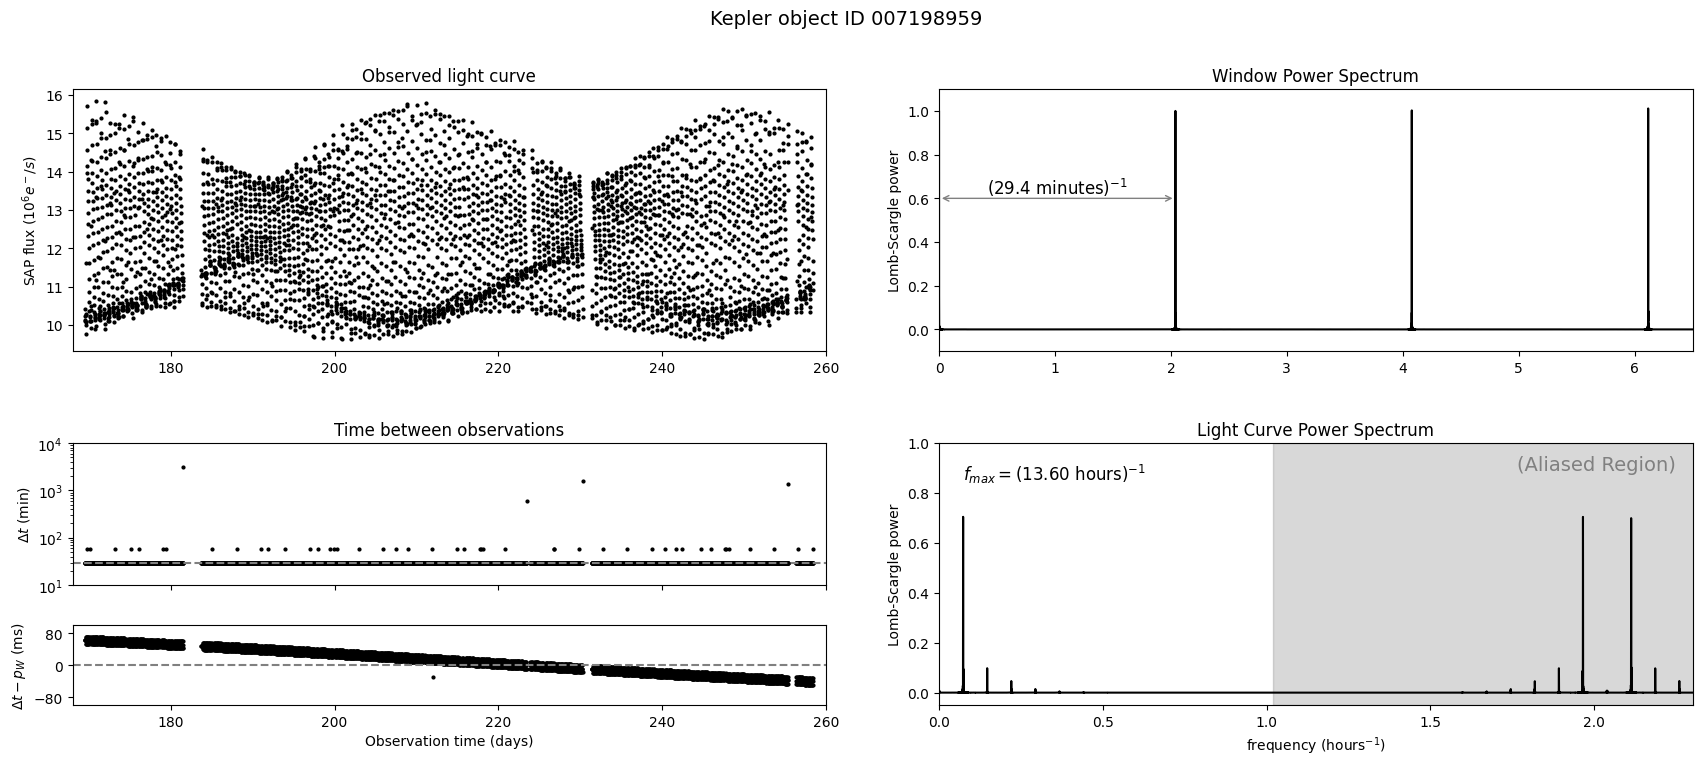

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))

fig.suptitle('Kepler object ID 007198959', size=14)
fig.subplots_adjust(hspace=0.35, wspace=0.15, left=0.07, right=0.97)

# upper left
ax[0, 0].plot(df['TIME'], df['SAP_FLUX'] / 1E6, 'ok', markersize=2, rasterized=True)
ax[0, 0].set(ylabel='SAP flux ($10^6 e^-/s$)',
             title='Observed light curve',
             xlim=(168, 260))

# bottom left
left, bottom, width, height = ax[1, 0].get_position().bounds
ax[1, 0].set_position([left, bottom + 0.15, width, height-0.15])
inset = fig.add_axes([left, bottom, width, 0.1])

ax[1, 0].plot(t_sorted[:-1], delta_t / 60, 'ok', markersize=2, rasterized=True)
ax[1, 0].axhline(p_ny / 60, color='gray', linestyle='--')
ax[1, 0].set(xlim=ax[0, 0].get_xlim(),
             ylim=(10, 10000),
             yscale='log',
             ylabel='$\Delta t$ (min)',
             title='Time between observations')
ax[1, 0].xaxis.set_major_formatter(plt.NullFormatter())

inset.plot(t_sorted[:-1], 1000 * (delta_t - p_ny), 'ok', markersize=2, rasterized=True)
inset.axhline(0, color='gray', linestyle='--')
inset.set(xlim=ax[0, 0].get_xlim(),
          ylim=(-100, 100),
          xlabel='Observation time (days)',
          ylabel='$\Delta t - p_{W}$ (ms)')
inset.yaxis.set_major_locator(plt.MaxNLocator(3));

# Upper right
ax[0, 1].plot(freqW / 24, powerW, '-k', rasterized=True);
ax[0, 1].set(xlim=(0, 6.5),
             ylim=(-0.1, 1.1),
             ylabel='Lomb-Scargle power',
             title='Window Power Spectrum');
ax[0, 1].annotate('', (0, 0.6), (f_ny / 24, 0.6),
                  arrowprops=dict(arrowstyle='<->', color='gray'));
ax[0, 1].text(f_ny / 48, 0.6, r'$({0:.1f}\ {{\rm minutes}})^{{-1}}$'.format(24 * 60 / f_ny),
              size=12, ha='center', va='bottom');

# Lower right
ax[1, 1].plot(freq / 24, power, '-k', rasterized=True)
ax[1, 1].fill_between([0.5 * f_ny / 24, 1.5 * f_ny / 24], -0.05, 1,
                      color='gray', alpha=0.3)
ax[1, 1].text(2.25, 0.95, r"(Aliased Region)", size=14, color='gray', ha='right', va='top')
ax[1, 1].text(fmax, 0.85, r"$f_{{max}}=({0:.2f}\ {{\rm hours}})^{{-1}}$".format(1 / fmax),
              size=12)
ax[1, 1].set(xlim=(0, 2.3),
             ylim=(-0.05, 1.0),
             xlabel='frequency (hours$^{-1}$)',
             ylabel='Lomb-Scargle power',
             title='Light Curve Power Spectrum');

#fig.savefig('fig16_kepler_data.pdf')

Best period: 0.57 days


Text(0.5, 0, 'Phase')

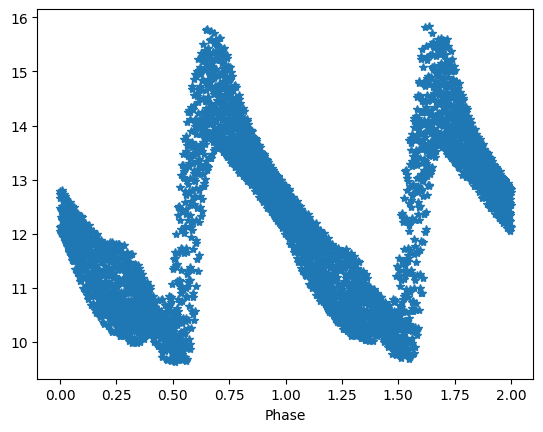

In [15]:
best_period = 1./freq[np.argmax(power)]
print("Best period: {:.2f} days".format(best_period))
phase = (df['TIME'] / best_period) % 2
plt.errorbar(phase, df['SAP_FLUX']/1e6, df['SAP_FLUX_ERR']/1e6,fmt='*')
plt.xlabel("Phase")